# Project: ML - Multivariate Linear Regression (Predicting Stock Market values)

<br>

## Questions to address:
- Predict stock value from historical data

<br>

## Tools:
- Models:
  - sklearn Multivariate LR (using Ordinary Least Squares)
- Error Metric: MSE and MAE
- Holdout Validation 

<br>

### load defaults

In [130]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import requests 

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import matplotlib.dates as mdates
from datetime import datetime
from IPython.display import display, Math

from functions import *

plt.rcParams.update({'axes.titlepad': 20, 'font.size': 14, 'axes.titlesize':20})

colors = [(0/255,107/255,164/255), (255/255, 128/255, 14/255), 'red', 'green', '#9E80BA', '#8EDB8E', '#58517A']
Ncolors = 10
color_map = plt.cm.Blues_r(np.linspace(0.2, 0.5, Ncolors))
#color_map = plt.cm.tab20c_r(np.linspace(0.2, 0.5, Ncolors))


#specific to this project
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

print("Defaults Loaded")

Defaults Loaded


<br>

## Dataset: Historical data for a stock index

In [132]:
df = pd.read_csv('./data/sphist.csv')

#covert date to datetime object
df['Date'] = pd.to_datetime(df['Date'])
#sort df by date in ascending order
df.sort_values('Date', ascending=True, inplace=True)
#re-index
df = df.reset_index(drop=True)

display(df[df['Date']>datetime(year=2015, month=11, day=1)].iloc[:5])

,Date,Open,High,Low,Close,Volume,Adj Close
16565,2015-11-02,2080.760010,2106.199951,2080.760010,2104.050049,3.760020e+09,2104.050049
16566,2015-11-03,2102.629883,2116.479980,2097.510010,2109.790039,4.272060e+09,2109.790039
16567,2015-11-04,2110.600098,2114.590088,2096.979980,2102.310059,4.078870e+09,2102.310059
16568,2015-11-05,2101.679932,2108.780029,2090.409912,2099.929932,4.051890e+09,2099.929932
16569,2015-11-06,2098.600098,2101.909912,2083.739990,2099.199951,4.369020e+09,2099.199951


- data on stocks is not independent (depends on previous values)
- extra careful to not inject future knowledge into past rows (algorithm will look very good on trainning set, but fail on test)
- price is the close column

<br>

### Feature Preparation, Selection and Engineering

- we can create indicators to make the model more accurate (e.g. average price for the last 10 trades): 
  - 5 day average, 30 day average, 365 day average
  - 5 day average / 365 day average
  - std(5 day average), std(365 day average)
  - std(5 day average) / std(365 day average)

In [133]:
#rolling mean uses the current day price so we need to roll forward
df['avg_5'] = df['Close'].rolling(window=5, center=False).mean().shift(1)
df['avg_30'] = df['Close'].rolling(window=30, center=False).mean().shift(1)
df['avg_365'] = df['Close'].rolling(window=365, center=False).mean().shift(1)
df['avg_5_over_365'] = (df['Close'].rolling(window=5, center=False).mean().shift(1) / 
                        df['Close'].rolling(window=365, center=False).mean().shift(1))
df['std_5'] = df['Close'].rolling(window=5, center=False).std().shift(1)
df['std_365'] = df['Close'].rolling(window=365, center=False).std().shift(1)
df['std_5_over_365'] = (df['Close'].rolling(window=5, center=False).std().shift(1) / 
                        df['Close'].rolling(window=365, center=False).std().shift(1))

display(df[df['Date']>datetime(year=2015, month=11, day=1)].iloc[:3,:10])

,Date,Open,High,Low,Close,Volume,Adj Close,avg_5,avg_30,avg_365
16565,2015-11-02,2080.760010,2106.199951,2080.76001,2104.050049,3.760020e+09,2104.050049,2079.237988,1998.127323,2027.370685
16566,2015-11-03,2102.629883,2116.479980,2097.51001,2109.790039,4.272060e+09,2109.790039,2085.812012,2002.696659,2027.950302
16567,2015-11-04,2110.600098,2114.590088,2096.97998,2102.310059,4.078870e+09,2102.310059,2094.592041,2008.264994,2028.523617


remove NaN, rows where the index could not be calculated 

In [134]:
#(in the first year, there are not enough rows to compute year average)
print("Len with Nans: {:d}".format(len(df)))
df.dropna(how='any', inplace=True, axis=0)
print("Len without Nans: {:d}".format(len(df)))

Len with Nans: 16590
Len without Nans: 16225


create train and test

In [135]:
#create train and test (train everything before 2013-01-01)
train = df[df['Date']<datetime(year=2013, month=1, day=1)]
test = df[df['Date']>=datetime(year=2013, month=1, day=1)]
print(len(train), len(test))

15486 739


<br>

### Predictions vs data

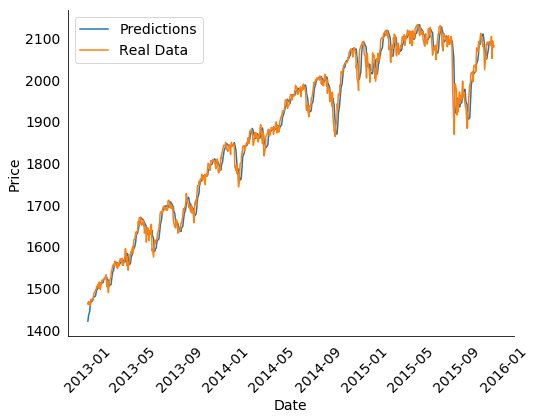

In [142]:
error_metric = 'MAE'
#error_metric = 'MSE'
cols = ['avg_5', 'avg_30', 'avg_365']
cols = ['avg_5']
cols = ['avg_5', 'avg_30', 'avg_365', 'avg_5_over_365', 'std_5', 'std_365', 'std_5_over_365']

model = LinearRegression()
model.fit(train[cols], train['Close'])
predictions = model.predict(test[cols])

if(error_metric == 'MAE'):
    error = mean_absolute_error(test['Close'], predictions)
else:
    error = mean_squared_error(test['Close'], predictions)
    
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(test['Date'], predictions, label = 'Predictions')
plt.plot(test['Date'], test['Close'], label='Real Data')


plt.xlabel('Date'), plt.ylabel('Price')
ax.tick_params(left=False, right=False, top=False, bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=45)

plt.legend()
plt.show()

Lets look at the difference between predictions and real values

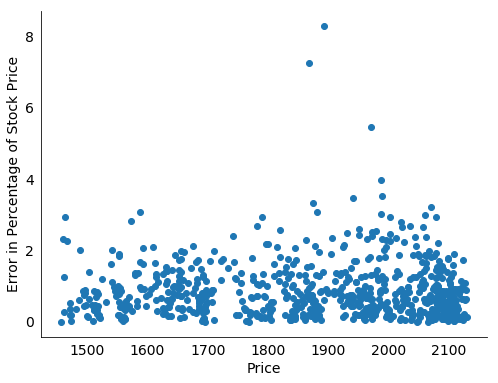

In [137]:
fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(test['Close'], np.abs(predictions-test['Close'])/test['Close']*100.)
plt.xlabel('Price'), plt.ylabel('Error in Percentage of Stock Price')

ax.tick_params(left=False, right=False, top=False, bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

 Compare errors with average price difference in a day

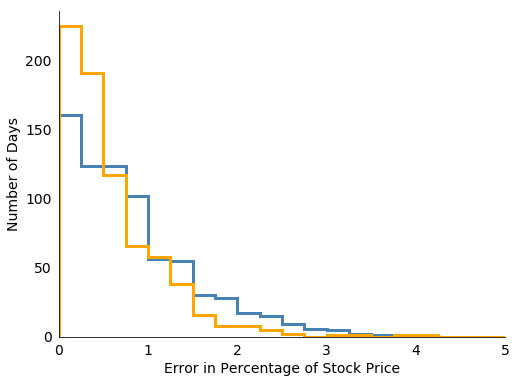

In [138]:
xlim = [0, 5.]
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(np.abs(predictions-test['Close'])/test['Close']*100., bins=20, range=(0,5.), fill=False, 
        histtype='step', color='steelblue', linewidth=3)

day_gain = np.abs(test['Close'].diff()/test['Close']*100.).dropna()

ax.hist(day_gain, bins=20, range=(0,5.), fill=False, 
        histtype='step', color='orange', linewidth=3)

ax.set_xlim(xlim)
ax.tick_params(left=False, right=False, top=False, bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Error in Percentage of Stock Price'), plt.ylabel('Number of Days')

plt.show()

On average the predictions are larger than the stock variation from day to day, the model is therefore not good enough

<br>
<br>
<br>

## Trading strategy based on  Inflexion points

- identify inflexion points
- this should be marked differently if the overall stock is going up or down (based on the difference between the past 100 and 200 day average)

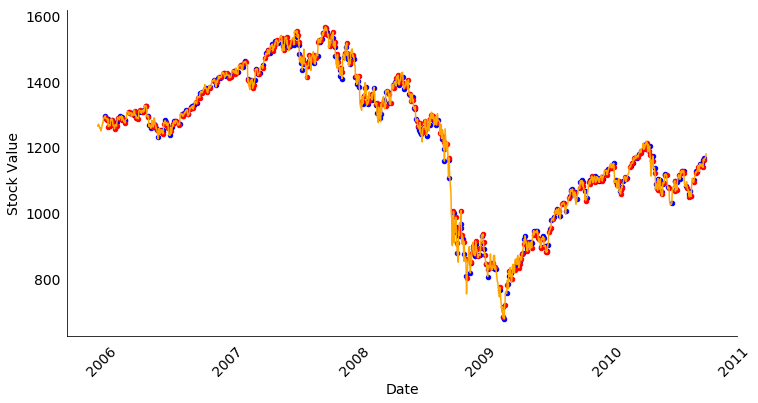

In [127]:
date_init = datetime(year=2006, month=1, day=6)

turn_df = pd.DataFrame({'Date' : [], 'Close' : [], 'Turn' : []})
turn_current_df = pd.DataFrame({'Date' : [], 'Close' : [], 'Turn' : []})

date = []
mean_past_100 = []
mean_past_200 = []

N_days = 1200
#N_days = 30
for i_day in range(0, N_days): 
    current_day = df.loc[df[df['Date']==date_init].index+i_day]
    day_minus_1 = df.loc[df[df['Date']==date_init].index+i_day-1]
    day_minus_2 = df.loc[df[df['Date']==date_init].index+i_day-2]
    day_minus_3 = df.loc[df[df['Date']==date_init].index+i_day-3]
    
    index_start = df[df['Date']==date_init].index[0]+i_day    
    mean_past_200 = np.mean(df['Close'].loc[index_start-200:index_start+i_day])
    mean_past_100 = np.mean(df['Close'].loc[index_start-100:index_start+i_day])
    
    #mean_past_200 = 10
    #mean_past_100 = 10  
    #past day is inflexion point if bigger that today and two days ago
    #or past day is small that today and two days ago
    #invert wether the overall stock is going up or down
    if(mean_past_100>=mean_past_200):
        if((day_minus_1['Close'].values>=day_minus_2['Close'].values) & 
           (day_minus_1['Close'].values>current_day['Close'].values)):             
            turn_df.loc[i_day] = [current_day['Date'].iloc[0], current_day['Close'].iloc[0],'down']
        
        elif((day_minus_1['Close'].values<=day_minus_2['Close'].values) & 
             (day_minus_1['Close'].values<current_day['Close'].values)):               
            turn_df.loc[i_day] = [current_day['Date'].iloc[0],current_day['Close'].iloc[0],'up']
    else:
         if((day_minus_1['Close'].values>=day_minus_2['Close'].values) & 
           (day_minus_1['Close'].values>current_day['Close'].values)):                   
            turn_df.loc[i_day] = [current_day['Date'].iloc[0],current_day['Close'].iloc[0],'up']
        
         elif((day_minus_1['Close'].values<=day_minus_2['Close'].values) & 
             (day_minus_1['Close'].values<current_day['Close'].values)):               
            turn_df.loc[i_day] = [current_day['Date'].iloc[0],current_day['Close'].iloc[0],'down']

turn_df = turn_df.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(12,6))

#plot real data for the time frame when we have predictions including some past days
Past_Days = 10
loc = df[df['Date']==date_init].index
plt.plot(df['Date'].loc[loc[0]-Past_Days:loc[0]+N_days], df['Close'].loc[loc[0]-Past_Days:loc[0]+N_days], 
         color='orange')

#plot inflexion points
up = turn_df[turn_df['Turn']=='up']
plt.scatter(up['Date'].values, up['Close'], color='blue', s=20)
down = turn_df[turn_df['Turn']=='down']
plt.scatter(down['Date'].values, down['Close'], color='red', s=20)

ax.tick_params(left=False, right=False, top=False, bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Date'), plt.ylabel('Stock Value')

plt.xticks(rotation=45)
plt.show()

Investment strategy: 
- if the stock is overall going up: buy if starts going up, sell if it starts going down
- the oposite if the overall stock is going down

In [128]:
money = 10000
N_shares = 0 
for idx, row in turn_df.iterrows():    
    #print(idx)    
    if((idx==0) & (row['Turn']=='down')):
        continue
    else:        
        if(row['Turn']=='up'):            
            N_shares += int(money/row['Close'])        
            money = money % row['Close']          
        elif(row['Turn']=='down'):
            money += N_shares*row['Close']
            N_shares = 0        
    #print(N_shares, money)
        
money += N_shares*row['Close']
print("\nValoriation of 10000$ in time interval: {:0.2f}$".format(money-10000))
print("Money per day for 10000$ investment: {:0.2f}$".format((money/10000.-1)*100/(N_days/365.)))

loc = df[df['Date']==date_init].index
money = 10000*df['Close'].loc[loc[0]+N_days]/df['Close'].loc[loc[0]]
print("\nMarket Valoriation of 10000$ in time interval: {:0.2f}$".format(money-10000))
print("Money per day for 10000$ investment: {:0.2f}$".format((money/10000.-1)*100/(N_days/365.)))       


Valoriation of 10000$ in time interval: 8441.56$
Money per day for 10000$ investment: 25.68$

Market Valoriation of 10000$ in time interval: -835.12$
Money per day for 10000$ investment: -2.54$
